In [16]:
# data_type = {avg1, avg2, avg4, avg8, avg16}
data_type = 'avg1'

In [17]:
import h5py
import numpy as np

file_name = 'FMD_WF_'+str(data_type)+'_train.hdf5'    
f = h5py.File(file_name, 'r')
clean = f["clean_images"][:]
noisy = f["noisy_images"][:]
f.close()

In [18]:
print (clean.shape)
print (noisy.shape)

(2850, 512, 512)
(2850, 512, 512)


# 1. Generate noise (smooth) patches

In [19]:
global_size = 96
global_stride = 24
max_num_smooth_patches = 40000
_lambda = 0.42

In [20]:
import pywt
def smooth_area_detector(patch, _lambda=0.42):
    
    cA, (cH, cV, cD) = pywt.dwt2(patch,'haar')
    std_cA = np.std(cA)
    std_cH = np.std(cH)
    std_cV = np.std(cV)
    std_cD = np.std(cD)
    mean_std = (std_cA + std_cH + std_cV + std_cD) / 4.

    std_difference = (abs(std_cA-mean_std) + abs(std_cH-mean_std) + abs(std_cV-mean_std)+ abs(std_cD-mean_std))/4.

    if std_difference <= mean_std*_lambda:
        return True
    else:
        return False

In [21]:
def crop_smooth_patch(img, size, stride):
    
    cropped_smooth_patch_arr = []

    img_size_x = img.shape[0]
    img_size_y = img.shape[1]
    cropped_patch_size = size
    
    for x_axis in range(0,img_size_x,stride):
        for y_axis in range(0,img_size_y,stride):

            x_tmp_range = x_axis+cropped_patch_size
            y_tmp_range = y_axis+cropped_patch_size

            if x_tmp_range < img_size_x and y_tmp_range < img_size_y:
                cropped_patch = img[x_axis:x_tmp_range,y_axis:y_tmp_range]
                if smooth_area_detector(cropped_patch, _lambda = _lambda):
                    cropped_smooth_patch_arr.append(cropped_patch)
                        
    return cropped_smooth_patch_arr

In [22]:
from scipy.ndimage import imread

smooth_patches = []

for img_idx in range(noisy.shape[0]):
    img = noisy[img_idx]
    smooth_patches +=crop_smooth_patch(img, global_size, global_stride)
    if len(smooth_patches) >= max_num_smooth_patches:
        print ('over maximum number')
        break

over maximum number


In [23]:
print ('number of smooth patches : ', len(smooth_patches))

number of smooth patches :  40002


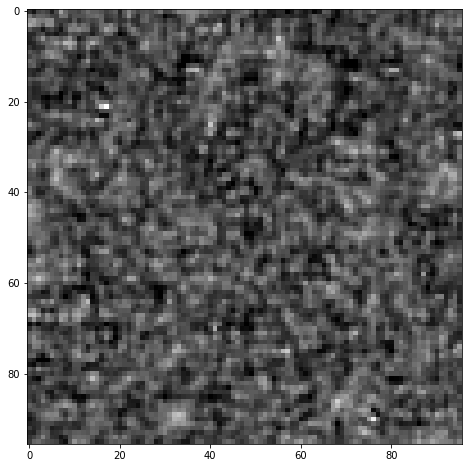

In [24]:
import matplotlib.pyplot as plt
idx_ = -3
plt.figure(figsize=[10,8])
plt.imshow(smooth_patches[idx_] - np.mean(smooth_patches[idx_]), cmap='gray')
plt.show()

In [25]:
file_name = 'GAN_train_96x96_FMD_WF_'+str(data_type)+'_noise_images.hdf5'    
# file_name = 'G2G_dataset_96x96_RealFM_WF_n_i_lambda42.hdf5'    
f = h5py.File(file_name, "w")
f.create_dataset('noise_patches', data=np.array(smooth_patches[:max_num_smooth_patches], dtype=np.float32))
f.close()

# 2. Generate noisy/clean patches

In [26]:
max_num_patches = len(smooth_patches)
patches_per_image = max_num_patches // (clean.shape[0]) + 1

print ('max_num_patches : ', max_num_patches)
print ('patches_per_image : ', patches_per_image)

max_num_patches :  40002
patches_per_image :  15


In [27]:
import random
def crop_random_patch(clean, noisy, size, num_patches):
    
    rand = random.randrange(1,100000)
    
    clean_patches = image.extract_patches_2d(clean, (size, size), num_patches, rand)
    noisy_patches = image.extract_patches_2d(noisy, (size, size), num_patches, rand)
    
    clean_img = clean_patches.copy()
    noisy_img = noisy_patches.copy()
    
    return clean_img, noisy_img

In [28]:
from sklearn.feature_extraction import image
from scipy.ndimage import imread

zi_patch = np.zeros((patches_per_image * (clean.shape[0]),global_size,global_size), dtype = np.float32)
xi_patch = np.zeros((patches_per_image * (noisy.shape[0]),global_size,global_size), dtype = np.float32)

patch_idx = 0

for img_idx in range(noisy.shape[0]):
    
    clean_img = clean[img_idx]
    noisy_img = noisy[img_idx]
    
    xi, zi = crop_random_patch(clean_img, noisy_img, global_size,patches_per_image)
    
    zi_patch[patch_idx:patch_idx+xi.shape[0]] = zi
    xi_patch[patch_idx:patch_idx+xi.shape[0]] = xi

    patch_idx += xi.shape[0]
    
    if patch_idx >= max_num_patches:
        print ('len of zi_patch, xi_patch : ', patch_idx)
        break

len of zi_patch, xi_patch :  40005


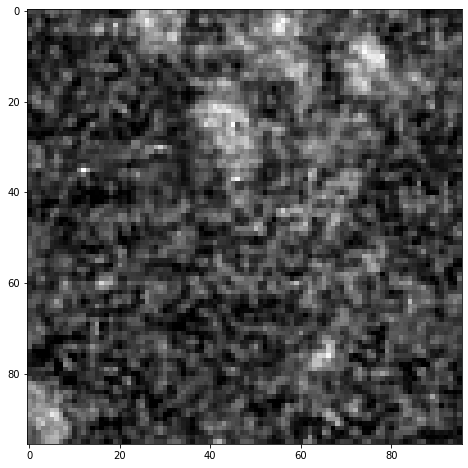

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,8])
plt.imshow(zi_patch[max_num_patches-1], cmap='gray')
plt.show()

In [30]:
import h5py
file_name = 'GAN_train_96x96_FMD_WF_'+str(data_type)+'_noisy_clean_images.hdf5'
# file_name = 'G2G_dataset_96x96_RealFM_WF_z_i_lambda42.hdf5'
f = h5py.File(file_name, "w")
f.create_dataset('clean_patches', data=np.array(xi_patch[:max_num_smooth_patches]))
f.create_dataset('noisy_patches', data=np.array(zi_patch[:max_num_smooth_patches]))
f.close()